### Librerias

In [237]:
#LIBRERIAS NECESARIAS
import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [238]:
# Temperatura, lluvia  x día

# Variables socioeconómicas x manzana:
#     Extraer coordenadas de cada barrio
#     Crear un centroido de 1km al rededor de cada barrio
#     Imputar el promedio de cada variable dentro de cada centroide

### Ordenamiento base econometría

In [249]:
dfc = pd.read_csv('1_PANEL_X_DELITOS/0_delitos_totales.csv', encoding="latin-1")

#### Correciones

Corrección de barrio

In [250]:
barrios = dfc[["barrio"]].drop_duplicates().sort_values(by = ["barrio"])

A = ["1Âº DE MAYO",
"BALNERIO HURTADO",
"CAÃAGUATE",
"CIUDADELA 450 AÃOS"
"DIVINO NIÃO"]

B = ["1º DE MAYO",
"BALNEARIO HURTADO",
"CAÑAGUATE",
"CIUDADELA 450 AÑOS",
"DIVINO NIÑO"]

for a,b in zip(A,B):
    dfc["barrio"] = dfc["barrio"].replace(a,b)

barrios = dfc[["barrio"]].drop_duplicates().sort_values(by = ["barrio"])

Merge de comuna

In [251]:
barrios = pd.read_excel("barrios.xlsx"); barrios.columns = ["barrio", "comuna"]
dfc = pd.merge(dfc, barrios, "left", "barrio")

# barrios["comuna"] = [random.randint(1, 7) for _ in range(len(barrios))]
#df.comuna = df.barrio

#### Filtros

Filtro de moviles

In [252]:
df = dfc.copy()

In [253]:
MOVIL = "TODOS"
# MOVIL = "MOTO"

if MOVIL == "MOTO":
    df = df[(df["móvil agresor"]=="CONDUCTOR MOTOCICLETA") |
            (df["móvil agresor"]=="PASAJERO MOTOCICLETA")]

Filtro de delito

In [254]:
# DICCIONARIO
# Todos = 0
# Homicidios en accidentes de tránsito = 1 
# Hurtos autos = 2
# Hurtos a comercio = 3
# Hurtos a residencias = 4 
# Homicidios = 5 
# Hurtos personas = 6
# Lesiones transito = 7

numero = 0
seleccion = ["T", "HT", "HA", "HC", "HR", "H", "HP", "LT"]
delito = seleccion[numero]

if numero>0 and MOVIL!="MOTO":
    df = df[df.tipo == delito]


#### Ordenamiento Panel

Panel

In [255]:
panel = df.groupby(["fecha", "comuna"])[["cantidad"]].sum().reset_index()
panel.fecha = pd.to_datetime(panel.fecha)

Balancear panel

In [256]:
from datetime import date, timedelta
from itertools import product

In [257]:
date_range = pd.date_range(start=panel.fecha.iloc[0], 
                           end=panel.fecha.iloc[-1], 
                           freq='D')

barrios = panel.comuna.unique()

combinations = product(date_range, barrios)

data = list(combinations)
data = pd.DataFrame(data, columns=['fecha', 'comuna'])

In [258]:
data = pd.merge(data, panel[["comuna"]].drop_duplicates("comuna"), "left", ['comuna'])
data = pd.merge(data, panel, "left", ['fecha', 'comuna'])
data.cantidad = data.cantidad.fillna(0)

In [ ]:
# data = panel.copy()

#### Creación de variables

Dia de la semana

In [ ]:
from datetime import datetime
data['dia'] = data['fecha'].apply(lambda x: x.strftime('%A'))

Crear controles de dias: dias antes y después del tratamiento, festivos

In [ ]:
from datetime import datetime

def dias_entre_fechas(fecha1, fecha2):
    # Convertir las fechas en objetos datetime si son cadenas
    if isinstance(fecha1, str):
        fecha1 = datetime.strptime(fecha1, "%Y-%m-%d")
    if isinstance(fecha2, str):
        fecha2 = datetime.strptime(fecha2, "%Y-%m-%d")
    
    # Calcular la diferencia entre las dos fechas
    diferencia = fecha2 - fecha1

    # Devolver la cantidad de días como un número entero
    return diferencia.days

In [ ]:
rangot = data[["fecha"]].drop_duplicates().reset_index(drop = True)

rangot["fecha_centrada"] = rangot["fecha"].apply(
    lambda x: 
    dias_entre_fechas(pd.to_datetime("2014-07-26"), x))

data = pd.merge(data, rangot, "left", "fecha")

Restringir base: 2 años y dos años después

In [ ]:
data = data[data.fecha_centrada>-731]
data = data[data.fecha_centrada<732]

Variables

In [ ]:
data["T"] = data.dia.apply(lambda x: 1 if x == "Saturday" else 0)
data["P"] = data.fecha_centrada.apply(lambda x: 1 if x>=0 else 0)
data["TP"] = data["T"]*data["P"]

In [ ]:
data["dian"] = data['fecha'].map(lambda x: (x.dayofweek + 1) % 7)
data["mesn"] = data['fecha'].map(lambda x: (x.month))
data["semanan"] = data['fecha'].map(lambda x: (np.ceil(x.day/7).astype(int)))

#### Gráfico tendencias paralelas

Graficos Tendencias paralelas

In [ ]:
import matplotlib.pyplot as plt
data["mes"] = data["fecha"].apply(lambda x: x.replace(day=1))
distribucion = data.groupby(["T", "mes"])["cantidad"].mean().reset_index()
control = distribucion[distribucion["T"]==0]
tratados = distribucion[distribucion["T"]==1]
datet = data[data.fecha_centrada==0]["fecha"].iloc[0]

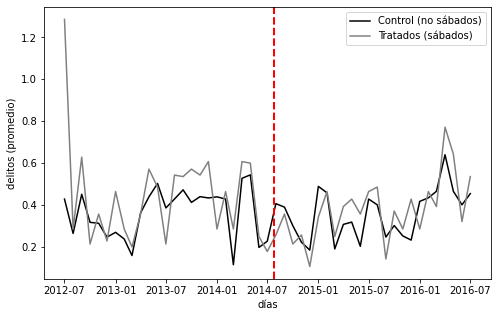

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(control["mes"], control["cantidad"], color="black")
plt.plot(tratados["mes"], tratados["cantidad"], color="gray")
# plt.text(0.98, 0.1, 'resto', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes, color="black")
# plt.text(0.98, 0.05, 'sábados', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes, color="gray")
# ax.set_xticks(ax.get_xticks()[1::])
ax.axvline(datet, color='r', linestyle='--', lw=2)
plt.legend(["Control (no sábados)", "Tratados (sábados)"])
plt.xlabel("días")
plt.ylabel("delitos (promedio)")
# plt.title("sábados vs resto de días")
plt.savefig(f"3_IMAGENES/TP_{MOVIL}_{delito}.jpeg", dpi = 200)

### Estimaciones

Librerias

In [ ]:
import statsmodels.api as sm
from tqdm import tqdm
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats import norm

Funciones importantes

In [ ]:
#TABLA FINAL DE REGRESIÓN
tabla_reg = pd.DataFrame(columns = ["TODOS"])

#FUNCIÓN PARA AGREGAR ESTRELLITAS
def reemplazar_texto(numero):
    texto_original = f"{numero}"
    if numero < 0.01:
        return texto_original.replace(str(numero), '***')
    elif numero < 0.05:
        return texto_original.replace(str(numero), '**')
    elif numero < 0.1:
        return texto_original.replace(str(numero), '*')
    else:
        return ''

#### DiD estandar

In [ ]:
Y = data["cantidad"]
X = data[["T", "P", "TP"]]; X = sm.add_constant(X)
dd = sm.OLS(Y, X).fit(cov_type='cluster', cov_kwds={'groups': data['comuna']})

###TABLA
param = round(dd.params["TP"],4)
error = round(dd.bse["TP"],4)
estrella =  reemplazar_texto(dd.pvalues["TP"])
tfinal = f"{param} ({error}){estrella}"

tabla_reg.loc["DD estándar", "TODOS"] = ""
tabla_reg.loc["DD", "TODOS"] = tfinal

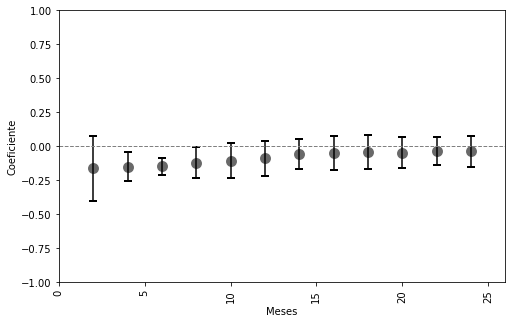

In [ ]:
# intervalos de tiempo en meses (un mes se considera como 30 días)
meses = list(range(2, 25, 2))[::-1]  # desde 24 hasta 2

# listas para guardar los resultados
params = []
conf_int_lower = []
conf_int_upper = []

for i in meses:
    dias = i * 30  # convierte meses en días

    # crea un subconjunto de los datos basado en el rango de tiempo alrededor del inicio de la política
    subdata = data.loc[np.abs(data['fecha_centrada']) <= dias]

    # ajusta el modelo OLS en el subconjunto de los datos
    Y = subdata["cantidad"]
    X = subdata[["T", "P", "TP"]]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit(cov_type='cluster', cov_kwds={'groups': subdata['comuna']})

    # guarda los resultados
    params.append(model.params['TP'])
    conf_int = model.conf_int().loc['TP']
    conf_int_lower.append(conf_int[0])
    conf_int_upper.append(conf_int[1])

# crear dataframe para los resultados
dfresults_plot = pd.DataFrame({'Meses': meses, 'Coeficiente': params, 'II': conf_int_lower, 'IS': conf_int_upper})

fig, ax = plt.subplots(1,1,figsize=(8,5)) 

# intervalos inferior y superior
sns.scatterplot(x = dfresults_plot['Meses'], y = dfresults_plot['II'], color = "black", marker = "_", s = 80, edgecolor='black', linewidth=2)
sns.scatterplot(x = dfresults_plot['Meses'], y = dfresults_plot['IS'], color = "black", marker = "_", s = 80, edgecolor='black', linewidth=2)

# lineas horizontales
for _, row in dfresults_plot.iterrows():
    plt.plot((row['Meses'], row['Meses']), (row['II'], row['IS']), c='black')

# valor del coeficiente
sns.scatterplot(x = dfresults_plot['Meses'], y = dfresults_plot['Coeficiente'], color = "dimgray", marker = "o", s = 80, edgecolor='dimgray', linewidth=2)

# lineas
ax.axhline(0, color='gray', linestyle='--', lw=1)
# ax.axvline(0, color='red', linestyle='--', lw=1)

# ajustar los ticks del eje x
# ax.set_xticks(ax.get_xticks()[::1])

plt.xlabel("Meses")
plt.ylabel("Coeficiente")

# condiciones
ax.set_ylim([-1, 1])
ax.set_xlim([0, 26])
plt.xticks(rotation=90)

# guardamos la imagen y la tabla
plt.savefig(f"3_IMAGENES/ROLLING_{MOVIL}_{delito}.jpeg", dpi = 200)
# dfresults_plot.to_excel(f"4_TABLAS/ES_{MOVIL}_{delito}.xlsx")

# mostramos la grafica
plt.show()


#### DiD: TWFE (Con efectos fijos)

In [ ]:
#ESTIMACIÓN
formula = "cantidad ~ TP + C(comuna)+ C(dian)+ C(semanan)+ C(mesn)"
dd = smf.ols(formula, data=data).fit(cov_type="cluster", cov_kwds={"groups": data["comuna"]})

#TABLA
param = round(dd.params["TP"],4)
error = round(dd.bse["TP"],4)
estrella =  reemplazar_texto(dd.pvalues["TP"])
tfinal = f"{param} ({error}){estrella}"

tabla_reg.loc["DD de efectos fijos", "TODOS"] = ""
tabla_reg.loc["TWFE", "TODOS"] = tfinal

#### DiD: Estudio de eventos

Saltos

In [ ]:
#2 MESES
saltos = 56 

#LEADS Y LAGS
leads = [i for i in range(saltos,731,saltos)]
lags = [-i for i in leads][1::][::-1]
ltotal = lags + leads

#ECUACIÓN
tp = ""
coefs = []
fecha_i = []

for i in ltotal:
    x = f"T_{i}".replace("-", "M")
    data[x] = data["fecha_centrada"].apply(lambda x: 1 if x>i else 0)
    tp = tp + x + "+"
    coefs.append(x)
    fecha_i.append(i)

tp = tp[::-1][1:][::-1]

#ESTIMACIÓN
formula = f"cantidad ~ C(comuna)+ C(dian)+ C(semanan)+ C(mesn)+{tp}"
dd = smf.ols(formula, data=data).fit(cov_type="cluster", cov_kwds={"groups": data["comuna"]})

In [ ]:
coefsd = pd.DataFrame(index = coefs, columns = ["II", "T", "IS", "P", "SE"])

for coef in coefs:
    coefsd.loc[coef, "II"], coefsd.loc[coef, "IS"] = dd.conf_int().loc[coef]
    coefsd.loc[coef, "T"] = dd.params[coef]
    coefsd.loc[coef, "P"] = dd.pvalues[coef]
    coefsd.loc[coef, "SE"] = dd.bse[coef]

coefsd.index = [int(i/28) for i in ltotal]

####################################
####################################


#AÑADIR VALORES A LA TABLA
for i in coefsd.index[:]:

    param = round(coefsd.loc[i, "T"],4)
    error = round(coefsd.loc[i, "SE"],4)
    estrella =  reemplazar_texto(coefsd.loc[i, "P"])
    tfinal = f"{param} ({error}){estrella}"

    tabla_reg.loc["DD Event Study", "TODOS"] = ""
    tabla_reg.loc[i, "TODOS"] = tfinal


tabla_reg.loc["", "TODOS"] = ""
tabla_reg.loc["N (comunas)", "TODOS"] = 7
tabla_reg.loc["N (comunas x días)", "TODOS"] = 7*(365*4)

Gráfica

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,5)) 

tupla_n = list(zip(coefsd.II, coefsd.IS))

#INTERVALO INFERIOR
sns.scatterplot(x = coefsd.index, y = coefsd.II,
    color = "black", marker = "_", s = 80, edgecolor='black', linewidth=2)
#INTERVLO SUPERIOR
sns.scatterplot(x = coefsd.index, y = coefsd.IS,
    color = "black", marker = "_", s = 80, edgecolor='black', linewidth=2)

#LINEAS HORIZONTALES
plt.plot((coefsd.index,coefsd.index),([i for (i,j) in tupla_n], [j for (i,j) in tupla_n]),c='black')

#VALOR COEFICIENTE
sns.scatterplot(x = coefsd.index, y = coefsd["T"],
    color = "dimgray", marker = "o", s = 80, edgecolor='dimgray', linewidth=2)
#LINEAS
ax.axhline(0, color='gray', linestyle='--', lw=1)
ax.axvline(0, color='red', linestyle='--', lw=1)
ax.set_xticks(ax.get_xticks()[:10:1])
plt.xlabel("Meses")
plt.ylabel("Coeficiente")

#CONDICIONES
ax.set_ylim([-1, 1])
plt.xticks(rotation=90)
plt.savefig(f"3_IMAGENES/ES_{MOVIL}_{delito}.jpeg", dpi = 200)
tabla_reg.to_excel(f"4_TABLAS/ES_{MOVIL}_{delito}.xlsx")